# KMP Algorithm: Graphical Analysis

This notebook provides a graphical performance analysis of the KMP (Knuth–Morris–Pratt) exact pattern matching algorithm for DNA sequences.

Notation:
- n = length of the text (len(text))
- m = length of the pattern (len(pattern))

Reference and attribution:
- KMP algorithm and LPS (computeLPSArray) flow adapted from GeeksforGeeks (ported from C++):
  https://www.geeksforgeeks.org/kmp-algorithm-for-pattern-searching/

In [1]:
# Setup: imports and environment
import os, sys, time, json

# Ensure this notebook can import from the KMP package directory
sys.path.append(os.path.abspath("."))  # current folder (should be STARK/KMP)

try:
    import matplotlib.pyplot as plt
except ImportError:
    import sys as _sys
    !{_sys.executable} -m pip install -q matplotlib
    import matplotlib.pyplot as plt

from kmp import KMP, search_multiple_patterns, find_approximate_matches
from utils import generate_random_dna

plt.rcParams["figure.figsize"] = (8, 4.8)
plt.rcParams["axes.grid"] = True

def time_call(func, *args, **kwargs):
    start = time.perf_counter()
    result = func(*args, **kwargs)
    end = time.perf_counter()
    return result, (end - start)

## Experiment 1: Impact of Pattern Length (fixed text length)

We fix the text length (n) and vary pattern length (m).

Method:
- Generate a random DNA text of length n
- For each m in a range, take a substring from the text as pattern (to ensure matches exist)
- Run KMP.search and record time
- Plot m vs. time (ms)

In [2]:
import statistics as stats

def benchmark_pattern_length(n=1_000_000, pattern_lengths=(5, 10, 20, 50, 100, 200, 400, 800), trials=50, seed_text=42):
    text = generate_random_dna(n, seed=seed_text)
    results = []
    for m in pattern_lengths:
        # Use a slice from text to ensure at least one match
        pattern = text[1000:1000+m]
        kmp = KMP(pattern)
        times = []
        for _ in range(trials):
            _, t = time_call(kmp.search, text)
            times.append(t)
        results.append({
            "pattern_length": m,
            "n": n,
            "time_seconds_mean": stats.mean(times),
            "time_seconds_min": min(times),
            "time_seconds_max": max(times),
            "matches_found": len(kmp.search(text)),
        })
    return results

pattern_len_results = benchmark_pattern_length()
pattern_len_results

[{'pattern_length': 5,
  'n': 1000000,
  'time_seconds_mean': 0.10784849446004956,
  'time_seconds_min': 0.10385970700008329,
  'time_seconds_max': 0.13115711499995086,
  'matches_found': 983},
 {'pattern_length': 10,
  'n': 1000000,
  'time_seconds_mean': 0.1056703084014589,
  'time_seconds_min': 0.10409930400783196,
  'time_seconds_max': 0.10990339300769847,
  'matches_found': 2},
 {'pattern_length': 20,
  'n': 1000000,
  'time_seconds_mean': 0.10556211592018372,
  'time_seconds_min': 0.10334156001044903,
  'time_seconds_max': 0.12195852700097021,
  'matches_found': 1},
 {'pattern_length': 50,
  'n': 1000000,
  'time_seconds_mean': 0.10515367111947853,
  'time_seconds_min': 0.10334086799412034,
  'time_seconds_max': 0.11060684599215165,
  'matches_found': 1},
 {'pattern_length': 100,
  'n': 1000000,
  'time_seconds_mean': 0.1049218088996713,
  'time_seconds_min': 0.10345430500456132,
  'time_seconds_max': 0.1077603790035937,
  'matches_found': 1},
 {'pattern_length': 200,
  'n': 1000

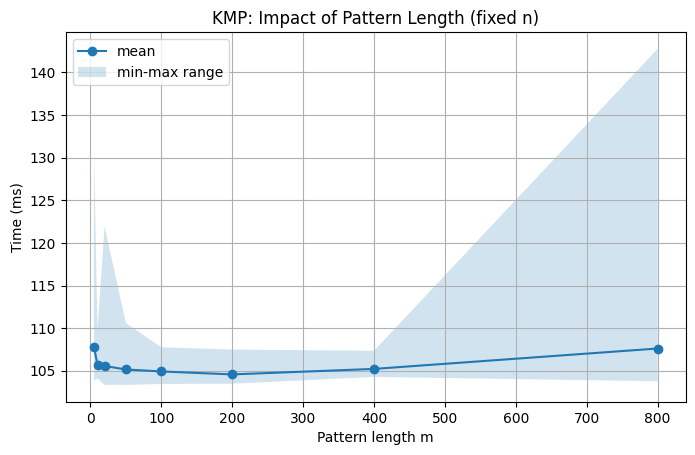

In [3]:
# Plot: m vs time (ms)
ms = [r["time_seconds_mean"] * 1000 for r in pattern_len_results]
ms_min = [r["time_seconds_min"] * 1000 for r in pattern_len_results]
ms_max = [r["time_seconds_max"] * 1000 for r in pattern_len_results]
m_values = [r["pattern_length"] for r in pattern_len_results]

plt.figure()
plt.plot(m_values, ms, marker='o', label='mean')
plt.fill_between(m_values, ms_min, ms_max, alpha=0.2, label='min-max range')
plt.xlabel('Pattern length m')
plt.ylabel('Time (ms)')
plt.title('KMP: Impact of Pattern Length (fixed n)')
plt.legend()
plt.show()

## Experiment 2: Impact of Text Length (fixed pattern length)

We fix the pattern length (m) and vary the text length (n).

Method:
- For each n in a range, generate random DNA text
- Keep a fixed m and select a known-in-text pattern
- Run KMP.search and record time
- Plot n vs. time (ms) and n vs. speed (million chars/sec)

In [4]:
def benchmark_text_length(text_lengths=(100_000, 500_000, 1_000_000, 2_000_000), m=50, trials=10, seed_pat=42):
    pattern_seed_text = generate_random_dna(1000 + m + 100, seed=seed_pat)
    pattern = pattern_seed_text[100:100+m]  # ensure fixed m across runs
    results = []
    for n in text_lengths:
        text = generate_random_dna(n, seed=100)
        kmp = KMP(pattern)
        times = []
        for _ in range(trials):
            _, t = time_call(kmp.search, text)
            times.append(t)
        t_mean = stats.mean(times)
        cps = (n / t_mean) if t_mean > 0 else float('inf')
        results.append({
            "n": n,
            "pattern_length": m,
            "time_seconds_mean": t_mean,
            "time_seconds_min": min(times),
            "time_seconds_max": max(times),
            "chars_per_second": cps,
            "Mchars_per_second": cps / 1e6
        })
    return results

text_len_results = benchmark_text_length()
text_len_results

[{'n': 100000,
  'pattern_length': 50,
  'time_seconds_mean': 0.011140883699408733,
  'time_seconds_min': 0.010801523996633478,
  'time_seconds_max': 0.01171556299959775,
  'chars_per_second': 8975948.649864031,
  'Mchars_per_second': 8.975948649864032},
 {'n': 500000,
  'pattern_length': 50,
  'time_seconds_mean': 0.056161003801389595,
  'time_seconds_min': 0.05378149800526444,
  'time_seconds_max': 0.05835703300544992,
  'chars_per_second': 8902974.771751292,
  'Mchars_per_second': 8.902974771751293},
 {'n': 1000000,
  'pattern_length': 50,
  'time_seconds_mean': 0.11284729090257314,
  'time_seconds_min': 0.10953625899855979,
  'time_seconds_max': 0.11634696600958705,
  'chars_per_second': 8861533.068289174,
  'Mchars_per_second': 8.861533068289173},
 {'n': 2000000,
  'pattern_length': 50,
  'time_seconds_mean': 0.22170250629715155,
  'time_seconds_min': 0.21420067199505866,
  'time_seconds_max': 0.2366984929976752,
  'chars_per_second': 9021097.836933637,
  'Mchars_per_second': 9.02

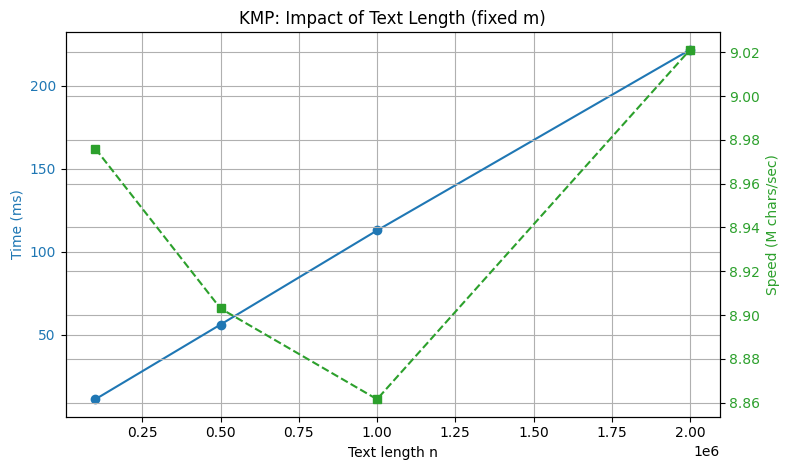

In [5]:
# Plot: n vs time (ms) and speed (M chars/sec)
n_values = [r["n"] for r in text_len_results]
time_ms = [r["time_seconds_mean"] * 1000 for r in text_len_results]
speed_mcs = [r["Mchars_per_second"] for r in text_len_results]

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Text length n')
ax1.set_ylabel('Time (ms)', color=color)
ax1.plot(n_values, time_ms, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
ax2.set_ylabel('Speed (M chars/sec)', color=color)
ax2.plot(n_values, speed_mcs, marker='s', linestyle='--', color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.title('KMP: Impact of Text Length (fixed m)')
fig.tight_layout()
plt.show()

## Experiment 3: Multiple Pattern Search

We evaluate total time to search for multiple patterns against the same text.

Method:
- Generate a fixed text of length n
- Create k patterns with varying m (by slicing from text)
- Use `search_multiple_patterns` and measure total time
- Summarize counts and total time

In [6]:
def benchmark_multiple_patterns(n=1_000_000, k=25, base_m=10):
    text = generate_random_dna(n, seed=42)
    patterns = []
    for i in range(k):
        m = base_m + 5 * i
        patterns.append(text[i*100 : i*100 + m])  # ensure matches
    matches_dict, t = time_call(search_multiple_patterns, text, patterns)
    total_matches = sum(len(v) for v in matches_dict.values())
    return {
        "n": n,
        "k": k,
        "total_time_ms": t * 1000,
        "total_matches": total_matches,
        "details": {p: len(matches_dict[p]) for p in patterns}
    }

mp_results = benchmark_multiple_patterns()
mp_results

{'n': 1000000,
 'k': 25,
 'total_time_ms': 2640.6613620056305,
 'total_matches': 26,
 'details': {'AAGCCCAATA': 2,
  'TTGAAGGAGTCTAGC': 1,
  'AAACCTTTCTACTATGTGTT': 1,
  'ACAGCTCAGGAGCCAGTCCCCTACG': 1,
  'AGGACGCCCAACTATTCTTTCCAATCCTAC': 1,
  'AGTGCTGGTGTGATAAGCAAACCACCCTACTGGCA': 1,
  'AGCTCGGTGTGGTGGGCACGACCCTGGACGCGCGACGAAG': 1,
  'CCGCAACGGTATGTGTTAATGGAACAGACTTGCTTATGTGGACGT': 1,
  'GAGGTCTTGGTTGCCTCTAGTTTCTACGATATACTCATGGTAGTGTAACG': 1,
  'GGGATGAATGCGCCGCAAGTAGCAGGTCCCGGCGTGGATACCTGATAGATGGTGA': 1,
  'ACAAGCCCACCCGCAGCCGCAACAGCGACGACTAATTGATCAGTAATTTATTAAGCACGG': 1,
  'GACCTCAGGAGCTAGACGGGGACCTACAACTTTGCGGGAACCAAGTTTTTGCAGTAGTGACTAAC': 1,
  'TACTTATGGCGCAACGGCCACGCCCACTTTGGCTATTGGAGAGTTAAGGAATTATCGTCATAGACACTTC': 1,
  'AGGCCGTCCCCAGAAGCTCCCCTATGCTGTCCGTCGTTGTTCCCGATGAAGACGTCTACTGATATGCTAGCAGAG': 1,
  'ATACCGTAGCTCAGAATTATGGAGAGCAGCAGGCTTCCATAGCACAGGTTGACGGAGGAGTTTTGCTTGGATATCGGAAG': 1,
  'ACACGGTACTGGTACGTGGCAACTTAGGTCGTCACATCTAGGAGGCCGCACCCTAGGTCAAGTTTTACGATTGCCCTAACGCCGC': 1,


## Save Results (optional)

You can save the experiment outputs to JSON for later comparison.

In [8]:
out = {
    "pattern_length": pattern_len_results,
    "text_length": text_len_results,
    "multiple_patterns": mp_results,
}
with open("kmp_nb_results.json", "w") as f:
    json.dump(out, f, indent=2)
print("Saved kmp_nb_results.json")

Saved kmp_nb_results.json


In [19]:
# Diagnostics: check matches and periodicity (via LPS) per m
import math

# Recreate the same text and pattern selection as in benchmark_pattern_length
n = 100_000
seed_text = 42
text = generate_random_dna(n, seed=seed_text)
pattern_lengths = (5, 10, 20, 50, 100, 200)

rows = []
for m in pattern_lengths:
    pattern = text[1000:1000+m]
    kmp_tmp = KMP(pattern)
    lps_end = kmp_tmp.lps[-1] if m > 0 else 0
    # A pattern is periodic if m % (m - lps_end) == 0 and lps_end > 0
    period = (m - lps_end) if (lps_end > 0 and (m - lps_end) > 0 and (m % (m - lps_end) == 0)) else None
    matches = len(kmp_tmp.search(text))
    rows.append({
        'm': m,
        'lps_last': lps_end,
        'period': period,
        'matches_found': matches,
    })

rows

[{'m': 5, 'lps_last': 0, 'period': None, 'matches_found': 95},
 {'m': 10, 'lps_last': 2, 'period': None, 'matches_found': 1},
 {'m': 20, 'lps_last': 0, 'period': None, 'matches_found': 1},
 {'m': 50, 'lps_last': 1, 'period': None, 'matches_found': 1},
 {'m': 100, 'lps_last': 0, 'period': None, 'matches_found': 1},
 {'m': 200, 'lps_last': 1, 'period': None, 'matches_found': 1}]

In [16]:
# Extended benchmark: KMP exact matching on large datasets (no Levenshtein/regex)
import timeit, tracemalloc, os, json, gzip
import pandas as pd
import matplotlib.pyplot as plt

# Extra imports to make this cell self-contained
from kmp import KMP, search_multiple_patterns
from utils import generate_random_dna

# Simple FASTA reader to avoid external deps

def read_fasta_concat(path, limit=None):
    """Concatenate all non-header lines from a FASTA file and return uppercase string.
    If limit is provided, return at most first `limit` characters.
    """
    try:
        seqs = []
        with open(path, 'r') as f:
            for line in f:
                if not line:
                    continue
                if line.startswith('>'):
                    continue
                seqs.append(line.strip())
        s = ''.join(seqs).upper()
        if limit is not None:
            return s if limit >= len(s) else s[:limit]
        return s
    except Exception as e:
        print(f"Error reading FASTA {path}: {e}")
        return ''


def get_genome_from_file_or_random(filepath, slice_size=None, seed=123):
    """Load genome sequence from FASTA `filepath` if present, else generate random DNA of length `slice_size`.
    Requires `slice_size` when filepath is not available.
    """
    if filepath and os.path.exists(filepath):
        seq = read_fasta_concat(filepath, limit=slice_size)
        return seq
    if slice_size is None:
        raise ValueError('slice_size must be provided when no genome file is available')
    return generate_random_dna(slice_size, seed=seed)


def list_fasta_files(root):
    """Recursively list FASTA-like files under `root`."""
    if not (root and os.path.exists(root)):
        return []
    exts = ('.fna', '.fa', '.fasta', '.fna.gz', '.fa.gz', '.fasta.gz')
    files = []
    for dirpath, _, filenames in os.walk(root):
        for fn in filenames:
            if fn.lower().endswith(exts):
                files.append(os.path.join(dirpath, fn))
    return sorted(files)


def ensure_dir(path):
    os.makedirs(path, exist_ok=True)
    return path


# Plot helpers (modified to return fig for saving)

def plot_kmp_scaling_results(df, title):
    if df.empty:
        print('No data to plot.')
        return None
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    fig.suptitle(f'{title}', fontsize=16)
    # Time
    ax1.plot(df['slice_size'], df['avg_time_s'], 'bo-', label='Average Time')
    ax1.set_title('Time vs Slice Size (n)')
    ax1.set_xlabel('Genome Slice Size (bp)')
    ax1.set_ylabel('Average Time (s)')
    ax1.grid(True)
    ax1.legend()
    ax1.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    # Memory
    ax2.plot(df['slice_size'], df['peak_memory_mb'], 'ro-', label='Peak Memory')
    ax2.set_title('Memory vs Slice Size (n)')
    ax2.set_xlabel('Genome Slice Size (bp)')
    ax2.set_ylabel('Peak Memory (MB)')
    ax2.grid(True)
    ax2.legend()
    ax2.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig



def run_kmp_scaling_analysis(filepath, slice_sizes, ensure_match=True, runs_small=5, runs_large=3):
    """Time and memory of KMP.search across slice sizes. If ensure_match, pattern is taken from text.
    Returns a DataFrame with slice_size, avg_time_s, peak_memory_mb.
    """
    results = []
    for size in slice_sizes:
        print(f"\n--- Slice Size: {size:,} bp ---")
        text = get_genome_from_file_or_random(filepath, size)
        # Choose pattern
        if ensure_match and size >= 110:
            m = 50 if size >= 200 else max(5, size // 4)
            pattern = text[100:100+m]
        else:
            m = 50 if size >= 200 else max(5, size // 4)
            pattern = generate_random_dna(m, seed=7)
        kmp = KMP(pattern)
        # Timing
        num_runs = runs_large if size > 10_000 else runs_small
        timer = timeit.Timer(lambda: kmp.search(text))
        total = timer.timeit(number=num_runs)
        avg = total / num_runs
        print(f"Avg Time: {avg:.6f} s (over {num_runs} runs)")
        # Memory
        tracemalloc.start()
        kmp.search(text)
        _, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        peak_mb = peak / 1024**2
        print(f"Peak Memory: {peak_mb:.4f} MB")
        results.append({'slice_size': size, 'avg_time_s': avg, 'peak_memory_mb': peak_mb})
    return pd.DataFrame(results)



def run_kmp_pattern_length(text, pattern_lengths=(5, 10, 20, 50, 100, 200, 400, 800), trials=10):
    """Fixed text; vary m. Pattern taken as substring from text to ensure matches."""
    results = []
    n = len(text)
    for m in pattern_lengths:
        if n < 1000 + m:
            # take from the beginning if text too short
            pattern = text[:m]
        else:
            pattern = text[1000:1000+m]
        kmp = KMP(pattern)
        times = []
        for _ in range(trials):
            _, t = timeit.Timer(lambda: kmp.search(text)).timeit(number=1), None  # ensure independent timing
            # Use perf_counter for accuracy instead of time_call from earlier cells
            import time as _t
            t0 = _t.perf_counter()
            kmp.search(text)
            t1 = _t.perf_counter()
            times.append(t1 - t0)
        # Memory once per m
        tracemalloc.start()
        kmp.search(text)
        _, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        results.append({
            'pattern_length': m,
            'n': n,
            'time_seconds_mean': sum(times)/len(times),
            'time_seconds_min': min(times),
            'time_seconds_max': max(times),
            'peak_memory_mb': peak / 1024**2,
            'matches_found': len(kmp.search(text)),
        })
    return pd.DataFrame(results)



def run_kmp_multiple_patterns(text, k=50, base_m=10, step=5):
    """Search multiple patterns (sliced from text) and report total time, total matches, and per-pattern counts."""
    patterns = []
    for i in range(k):
        m = base_m + step * i
        start = (i * 200) % max(1, (len(text) - m))
        patterns.append(text[start:start+m])
    # Time + Memory
    import time as _time
    tracemalloc.start()
    t0 = _time.perf_counter()
    matches_dict = search_multiple_patterns(text, patterns)
    t1 = _time.perf_counter()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    total_matches = sum(len(v) for v in matches_dict.values())
    details = {p: len(matches_dict[p]) for p in patterns}
    return {
        'n': len(text),
        'k': k,
        'total_time_ms': (t1 - t0) * 1000,
        'peak_memory_mb': peak / 1024**2,
        'total_matches': total_matches,
        'details': details,
    }



def run_kmp_extended_for_file(genome_filepath, strain_dir, fixed_n=1_000_000, sizes=(100_000, 250_000, 500_000, 750_000, 1_000_000),
                                multiple_k=50, base_m=10, step=5):
    """Run the 3 extended tests for a single FASTA file and save outputs under `strain_dir`."""
    ensure_dir(strain_dir)
    # Test 1: n scaling
    df_scale = run_kmp_scaling_analysis(genome_filepath, list(sizes), ensure_match=True)
    df_scale.to_csv(os.path.join(strain_dir, 'scaling_results.csv'), index=False)
    fig = plot_kmp_scaling_results(df_scale, f'KMP: Time/Memory vs Slice Size (n) - {os.path.basename(os.path.dirname(genome_filepath))}')
    if fig is not None:
        fig.savefig(os.path.join(strain_dir, 'scaling_time_memory.png'), dpi=150)
        plt.close(fig)
    # Test 2: pattern length at fixed n
    text_fixed = get_genome_from_file_or_random(genome_filepath, fixed_n)
    df_pl = run_kmp_pattern_length(text_fixed)
    df_pl.to_csv(os.path.join(strain_dir, 'pattern_length_results.csv'), index=False)
    # Plot pattern length (save instead of show)
    fig2, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
    ax1.plot(df_pl['pattern_length'], df_pl['time_seconds_mean']*1000, 'bo-', label='mean')
    ax1.fill_between(df_pl['pattern_length'], df_pl['time_seconds_min']*1000, df_pl['time_seconds_max']*1000, alpha=0.2, label='min-max')
    ax1.set_title('KMP: Impact of Pattern Length (fixed n)')
    ax1.set_xlabel('Pattern length m')
    ax1.set_ylabel('Time (ms)')
    ax1.grid(True)
    ax1.legend()
    ax2.plot(df_pl['pattern_length'], df_pl['peak_memory_mb'], 'ro-')
    ax2.set_title('Peak Memory vs m')
    ax2.set_xlabel('Pattern length m')
    ax2.set_ylabel('Peak Memory (MB)')
    ax2.grid(True)
    plt.tight_layout()
    fig2.savefig(os.path.join(strain_dir, 'pattern_length_time_memory.png'), dpi=150)
    plt.close(fig2)
    # Test 3: multiple patterns (large k)
    df_mp = run_kmp_multiple_patterns(text_fixed, k=multiple_k, base_m=10, step=5)
    with open(os.path.join(strain_dir, 'multiple_patterns_summary.json'), 'w') as f:
        json.dump({k: v for k, v in df_mp.items()}, f, indent=2)
    return {'scaling': df_scale, 'pattern_length': df_pl, 'multiple_patterns': df_mp}



def run_kmp_extended_all(data_root, out_dir='results', fixed_n=1_000_000, sizes=(100_000, 250_000, 500_000, 750_000, 1_000_000),
                         multiple_k=50, base_m=10, step=5, max_files=None):
    """Run extended benchmarks across all FASTA files under `data_root` and save images
    to `out_dir/<strain_name>/`."""
    files = list_fasta_files(data_root)
    if max_files is not None:
        files = files[:max_files]
    ensure_dir(out_dir)
    print(f'Found {len(files)} FASTA files under {data_root}')
    results = {}
    for i, fpath in enumerate(files, 1):
        strain = os.path.basename(os.path.dirname(fpath)) or os.path.splitext(os.path.basename(fpath))[0]
        strain_dir = os.path.join(out_dir, strain)
        print(f"\n[{i}/{len(files)}] {strain} -> {os.path.basename(fpath)}")
        try:
            res = run_kmp_extended_for_file(fpath, strain_dir, fixed_n=fixed_n, sizes=sizes, multiple_k=multiple_k, base_m=base_m, step=step)
            results[strain] = {'file': fpath, 'summary': {k: (v if not hasattr(v, 'to_dict') else v.to_dict()) for k, v in res.items()}}
            print(f"  Saved outputs to {strain_dir}")
        except Exception as e:
            print(f"  Error processing {strain}: {e}")
    return results


# Entry point: run on all strains and save images into results/<strain>
RUN_KMP_EXTENDED_ALL = True
if RUN_KMP_EXTENDED_ALL:
    DATA_ROOT = os.path.join('..', 'DnA_dataset', 'ncbi_dataset', 'data')
    _results = run_kmp_extended_all(DATA_ROOT, out_dir='results', fixed_n=1_000_000, sizes=(100_000, 250_000, 500_000, 750_000, 1_000_000),
                                    multiple_k=50, base_m=10, step=5, max_files=None)
    print('Extended KMP per-file benchmarking complete.')

Found 90 FASTA files under ../DnA_dataset/ncbi_dataset/data

[1/90] GCA_000005845.2 -> GCA_000005845.2_ASM584v2_genomic.fna

--- Slice Size: 100,000 bp ---
Avg Time: 0.010824 s (over 3 runs)
Peak Memory: 0.0955 MB

--- Slice Size: 250,000 bp ---
Avg Time: 0.026295 s (over 3 runs)
Peak Memory: 0.2393 MB

--- Slice Size: 500,000 bp ---
Avg Time: 0.026295 s (over 3 runs)
Peak Memory: 0.2393 MB

--- Slice Size: 500,000 bp ---
Avg Time: 0.052427 s (over 3 runs)
Avg Time: 0.052427 s (over 3 runs)
Peak Memory: 0.4802 MB

--- Slice Size: 750,000 bp ---
Peak Memory: 0.4802 MB

--- Slice Size: 750,000 bp ---
Avg Time: 0.079175 s (over 3 runs)
Avg Time: 0.079175 s (over 3 runs)
Peak Memory: 0.7186 MB

--- Slice Size: 1,000,000 bp ---
Peak Memory: 0.7186 MB

--- Slice Size: 1,000,000 bp ---
Avg Time: 0.103738 s (over 3 runs)
Avg Time: 0.103738 s (over 3 runs)
Peak Memory: 0.9571 MB
Peak Memory: 0.9571 MB
  Saved outputs to results/GCA_000005845.2

[2/90] GCA_000269645.2 -> GCA_000269645.2_PB_Esch_

In [ ]:
# Benchmark KMP across all genomes: run extended analyses per file and save images per strain
import os, time, tracemalloc, gzip, json
import pandas as pd

# Ensure imports available regardless of previous cells
try:
    import matplotlib.pyplot as plt
except ImportError:
    import sys as _sys
    !_sys.executable -m pip install -q matplotlib
    import matplotlib.pyplot as plt

from kmp import KMP

# Reuse functions defined earlier in the notebook (from the extended benchmarks cell):
# - read_fasta_concat, get_genome_from_file_or_random
# - run_kmp_scaling_analysis, run_kmp_pattern_length, run_kmp_multiple_patterns

# Root path to datasets (relative to this notebook directory STARK/KMP)
DATA_ROOT = os.path.abspath(os.path.join('..', 'DnA_dataset', 'ncbi_dataset', 'data'))

# Discover FASTA-like files under DATA_ROOT

def list_fasta_files(root):
    if not os.path.exists(root):
        print(f"Data root not found: {root}")
        return []
    exts = ('.fna', '.fa', '.fasta', '.fna.gz', '.fa.gz', '.fasta.gz')
    files = []
    for dirpath, _, filenames in os.walk(root):
        for fn in filenames:
            if fn.lower().endswith(exts):
                files.append(os.path.join(dirpath, fn))
    return sorted(files)


def ensure_dir(path):
    os.makedirs(path, exist_ok=True)
    return path


# Plot helpers that return fig for saving (avoid calling plt.show() here)

def plot_scaling_df(df, title):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    fig.suptitle(f'{title}', fontsize=16)
    ax1.plot(df['slice_size'], df['avg_time_s'], 'bo-', label='Average Time')
    ax1.set_title('Time vs Slice Size (n)')
    ax1.set_xlabel('Genome Slice Size (bp)')
    ax1.set_ylabel('Average Time (s)')
    ax1.grid(True)
    ax1.legend()
    ax1.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax2.plot(df['slice_size'], df['peak_memory_mb'], 'ro-', label='Peak Memory')
    ax2.set_title('Memory vs Slice Size (n)')
    ax2.set_xlabel('Genome Slice Size (bp)')
    ax2.set_ylabel('Peak Memory (MB)')
    ax2.grid(True)
    ax2.legend()
    ax2.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig


def plot_pattern_length_df(df, title):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
    ax1.plot(df['pattern_length'], df['time_seconds_mean']*1000, 'bo-', label='mean')
    ax1.fill_between(df['pattern_length'], df['time_seconds_min']*1000, df['time_seconds_max']*1000, alpha=0.2, label='min-max')
    ax1.set_title(f'{title}: Time vs Pattern Length (m)')
    ax1.set_xlabel('Pattern length m')
    ax1.set_ylabel('Time (ms)')
    ax1.grid(True)
    ax1.legend()
    ax2.plot(df['pattern_length'], df['peak_memory_mb'], 'ro-')
    ax2.set_title('Peak Memory vs m')
    ax2.set_xlabel('Pattern length m')
    ax2.set_ylabel('Peak Memory (MB)')
    ax2.grid(True)
    fig.tight_layout()
    return fig


# Orchestrator: run extended analyses per genome and save artifacts

def run_extended_on_all_genomes(data_root=DATA_ROOT, out_dir='kmp_all_genome_plots', fixed_n=1_000_000,
                                sizes=(100_000, 250_000, 500_000, 750_000, 1_000_000),
                                multiple_k=50, base_m=10, step=5, limit_bp=None, max_files=None):
    files = list_fasta_files(data_root)
    if max_files is not None:
        files = files[:max_files]

    ensure_dir(out_dir)

    overview_rows = []
    print(f"Found {len(files)} FASTA files under {data_root}")

    for i, fpath in enumerate(files, 1):
        strain_id = os.path.basename(os.path.dirname(fpath)) or os.path.splitext(os.path.basename(fpath))[0]
        strain_dir = ensure_dir(os.path.join(out_dir, strain_id))
        print(f"\n[{i}/{len(files)}] {strain_id} -> {os.path.basename(fpath)}")
        try:
            # Test 1: scaling with slice size
            df_scale = run_kmp_scaling_analysis(fpath, list(sizes), ensure_match=True)
            # Save CSV
            df_scale.to_csv(os.path.join(strain_dir, 'scaling_results.csv'), index=False)
            # Save plot
            fig1 = plot_scaling_df(df_scale, f'KMP Scaling: {strain_id}')
            fig1.savefig(os.path.join(strain_dir, 'scaling_time_memory.png'), dpi=150)
            plt.close(fig1)

            # Test 2: pattern length at fixed n (bounded by limit_bp if provided)
            FIXED_N = fixed_n if limit_bp is None else min(fixed_n, limit_bp)
            text_fixed = get_genome_from_file_or_random(fpath, FIXED_N)
            df_pl = run_kmp_pattern_length(text_fixed)
            df_pl.to_csv(os.path.join(strain_dir, 'pattern_length_results.csv'), index=False)
            fig2 = plot_pattern_length_df(df_pl, f'KMP Pattern Length ({strain_id})')
            fig2.savefig(os.path.join(strain_dir, 'pattern_length_time_memory.png'), dpi=150)
            plt.close(fig2)

            # Test 3: multiple patterns
            df_mp = run_kmp_multiple_patterns(text_fixed, k=multiple_k, base_m=base_m, step=step)
            with open(os.path.join(strain_dir, 'multiple_patterns_summary.json'), 'w') as f:
                json.dump({k: v for k, v in df_mp.items()}, f, indent=2)

            # Overview row (take an indicative speed from scaling: last point)
            if not df_scale.empty:
                last_row = df_scale.sort_values('slice_size').iloc[-1]
                overview_rows.append({
                    'strain': strain_id,
                    'slice_size': int(last_row['slice_size']),
                    'avg_time_s': float(last_row['avg_time_s']),
                    'peak_memory_mb': float(last_row['peak_memory_mb'])
                })

            print(f"  Saved results to {strain_dir}")
        except Exception as e:
            print(f"  Error processing {strain_id}: {e}")

    # Save overview and plots
    if overview_rows:
        overview_df = pd.DataFrame(overview_rows)
        overview_dir = ensure_dir(os.path.join(out_dir, 'overview'))
        overview_df.to_csv(os.path.join(overview_dir, 'overview_scaling_lastpoint.csv'), index=False)
        try:
            # Plot overview time and memory by strain (sorted by slice_size desc then time)
            plot_df = overview_df.sort_values(['slice_size', 'avg_time_s'], ascending=[False, True]).head(40)
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
            ax1.bar(plot_df['strain'], plot_df['avg_time_s'], color='tab:blue')
            ax1.set_title('KMP Time at Largest Slice Size per Strain')
            ax1.set_ylabel('Average Time (s)')
            ax1.tick_params(axis='x', rotation=75)
            ax2.bar(plot_df['strain'], plot_df['peak_memory_mb'], color='tab:red')
            ax2.set_title('KMP Peak Memory at Largest Slice Size per Strain')
            ax2.set_ylabel('Peak Memory (MB)')
            ax2.tick_params(axis='x', rotation=75)
            plt.tight_layout()
            fig.savefig(os.path.join(overview_dir, 'overview_time_memory.png'), dpi=150)
            plt.close(fig)
        except Exception as e:
            print(f"Overview plotting error: {e}")

    return True


# Toggle to run the extended benchmarks across all genome files and save images per strain
RUN_KMP_EXTENDED_ALL_FILES = False
if RUN_KMP_EXTENDED_ALL_FILES:
    _ = run_extended_on_all_genomes(
        data_root=DATA_ROOT,
        out_dir='kmp_all_genome_plots',
        fixed_n=1_000_000,
        sizes=(100_000, 250_000, 500_000, 750_000, 1_000_000),
        multiple_k=50,
        base_m=10,
        step=5,
        limit_bp=None,   # e.g., 1_000_000 to cap per-genome slice sizes
        max_files=None   # e.g., 10 for a quick sample
    )
    print('Extended KMP per-file benchmarking complete.')